In [1]:
%matplotlib ipympl
import time
import traceback
from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from onix.analysis.t_violation import TViolation
from uncertainties import ufloat

In [2]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None, bounds=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0, "c": 1, "b": 0, "sigma": 1})
    if p0 is not None:
        fitter.set_p0(p0)
    if bounds is not None:
        for bound_var, bound in bounds.items():
            fitter.set_bounds(bound_var, bound[0], bound[1])
    fitter.fit(maxfev = 10000)
    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) )
    
def gaussianC(f, f0, a, sigma, c): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) ) + c

def get_gaussianC_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussianC)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def two_peak_gaussian(f, f1, f2, a1, a2, sigma1, sigma2, b, c):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + c + b * f

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c

def linear(x, a, b):
    return x * a + b

In [3]:
def averaged_data_from_number(data_number):
    data, headers = get_experiment_data(data_number)
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    return (transmissions_avg, monitors_avg, headers)

In [4]:
def gaussian_fits_from_data(transmissions_avg, monitors_avg, headers, default_p0=None):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0

    p0 = {"sigma": 0.5, "a": -0.1, "b": 0.0001, "c": np.average(antihole_normalized)}
    if default_p0 is None:
        default_p0 = {}
    p0.update(default_p0)
    
    if not use_field_plate:
        fits = {0: {}}
        antihole_fit = get_gaussian_fit(detunings, antihole_normalized, p0=p0)
        fits[0]["ah"] = antihole_fit
        
        rf_fit = get_gaussian_fit(detunings, rf_normalized, p0=p0)
        fits[0]["rf"] = rf_fit
    else:
        fits = {1: {}, -1: {}}
        for label in fits.keys():
            use_positive_stark_shift = label > 0
            if use_positive_stark_shift:
                mask = detunings > 0
            else:
                mask = detunings < 0
            p0["f_0"] = label * abs(headers["params"]["field_plate"]["stark_shift"].to("MHz").magnitude)
            antihole_fit: Fitter = get_gaussian_fit(detunings[mask], antihole_normalized[mask], p0=p0)
            fits[label]["ah"] = antihole_fit
            
            rf_fit: Fitter = get_gaussian_fit(detunings[mask], rf_normalized[mask], p0=p0)
            fits[label]["rf"] = rf_fit
    return fits

In [5]:
def ah_parameters_from_data(transmissions_avg, monitors_avg, headers):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0
    
    if not use_field_plate:
        off_resonant_index = np.argmax(np.abs(detunings) > 0)
        on_resonant_index = 1 - off_resonant_index
        heights = {0: {}}
        backgrounds = {0: {}}
        heights[0]["ah"] = 1 - antihole_avg[on_resonant_index] / antihole_avg[off_resonant_index]
        heights[0]["rf"] = 1 - rf_avg[on_resonant_index] / rf_avg[off_resonant_index]
        backgrounds[0]["ah"] = antihole_avg[off_resonant_index]
        backgrounds[0]["rf"] = rf_avg[off_resonant_index]
    else:
        off_resonant_index_1 = 1
        off_resonant_index_2 = 0
        # off_resonant_index_2 = 1
        on_resonant_index_1 = 3
        on_resonant_index_2 = 2

        heights = {1: {}, -1: {}}
        backgrounds = {1: {}, -1: {}}

        heights[1]["ah"] = 1 - antihole_avg[on_resonant_index_1] / antihole_avg[off_resonant_index_1]
        heights[1]["rf"] = 1 - rf_avg[on_resonant_index_1] / rf_avg[off_resonant_index_1]
        heights[-1]["ah"] = 1 - antihole_avg[on_resonant_index_2] / antihole_avg[off_resonant_index_2]
        heights[-1]["rf"] = 1 - rf_avg[on_resonant_index_2] / rf_avg[off_resonant_index_2]

        backgrounds[1]["ah"] = antihole_avg[off_resonant_index_1]
        backgrounds[1]["rf"] = rf_avg[off_resonant_index_1]
        backgrounds[-1]["ah"] = antihole_avg[off_resonant_index_2]
        backgrounds[-1]["rf"] = rf_avg[off_resonant_index_2]
    return (heights, backgrounds)

In [6]:
def rf_spectroscopy_ah_ratio(data_numbers, method="auto"):
    rf_heights = {}
    antihole_heights = {}
    rf_backgrounds = {}
    antihole_backgrounds = {}
    headers = []
    for data_number in data_numbers:
        try:
            transmissions_avg, monitors_avg, headers_single = averaged_data_from_number(data_number)
            if method == "auto":
                detunings_len = len(headers_single["detunings"])
                if detunings_len > 4:
                    method = "fit"
                else:
                    method = "ratio"
            if method == "fit":
                try:
                    fits = gaussian_fits_from_data(transmissions_avg, monitors_avg, headers_single)
                except RuntimeError as e:
                    print(f"Fitting error for data number #{data_number}:")
                    raise e
                for label in fits:
                    if label not in rf_heights:
                        rf_heights[label] = []
                        antihole_heights[label] = []
                        rf_backgrounds[label] = []
                        antihole_backgrounds[label] = []
                    rf_heights[label].append(abs(fits[label]["rf"].results["a"]) / fits[label]["rf"].results["c"])
                    antihole_heights[label].append(abs(fits[label]["ah"].results["a"]) / fits[label]["ah"].results["c"])
                    rf_backgrounds[label].append(fits[label]["rf"].results["c"])
                    antihole_backgrounds[label].append(fits[label]["ah"].results["c"])
            elif method == "ratio":
                heights, backgrounds = ah_parameters_from_data(transmissions_avg, monitors_avg, headers_single)
                # heights, backgrounds = ah_parameters_from_data1(data_number)
                for label in heights:
                    if label not in rf_heights:
                        rf_heights[label] = []
                        antihole_heights[label] = []
                        rf_backgrounds[label] = []
                        antihole_backgrounds[label] = []
                    rf_heights[label].append(heights[label]["rf"])
                    antihole_heights[label].append(heights[label]["ah"])
                    rf_backgrounds[label].append(backgrounds[label]["rf"])
                    antihole_backgrounds[label].append(backgrounds[label]["ah"])
            headers.append(headers_single)
        except:
            continue
    for label in rf_heights:
        rf_heights[label] = np.array(rf_heights[label])
        antihole_heights[label] = np.array(antihole_heights[label])
        rf_backgrounds[label] = np.array(rf_backgrounds[label])
        antihole_backgrounds[label] = np.array(antihole_backgrounds[label])
    return (rf_heights, antihole_heights, rf_backgrounds, antihole_backgrounds, headers)

In [7]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

## Test HSH Pulse vs Sine Sweep

/home/icarus/.venv/vlab/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icarus/.venv/vlab/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must be the same size

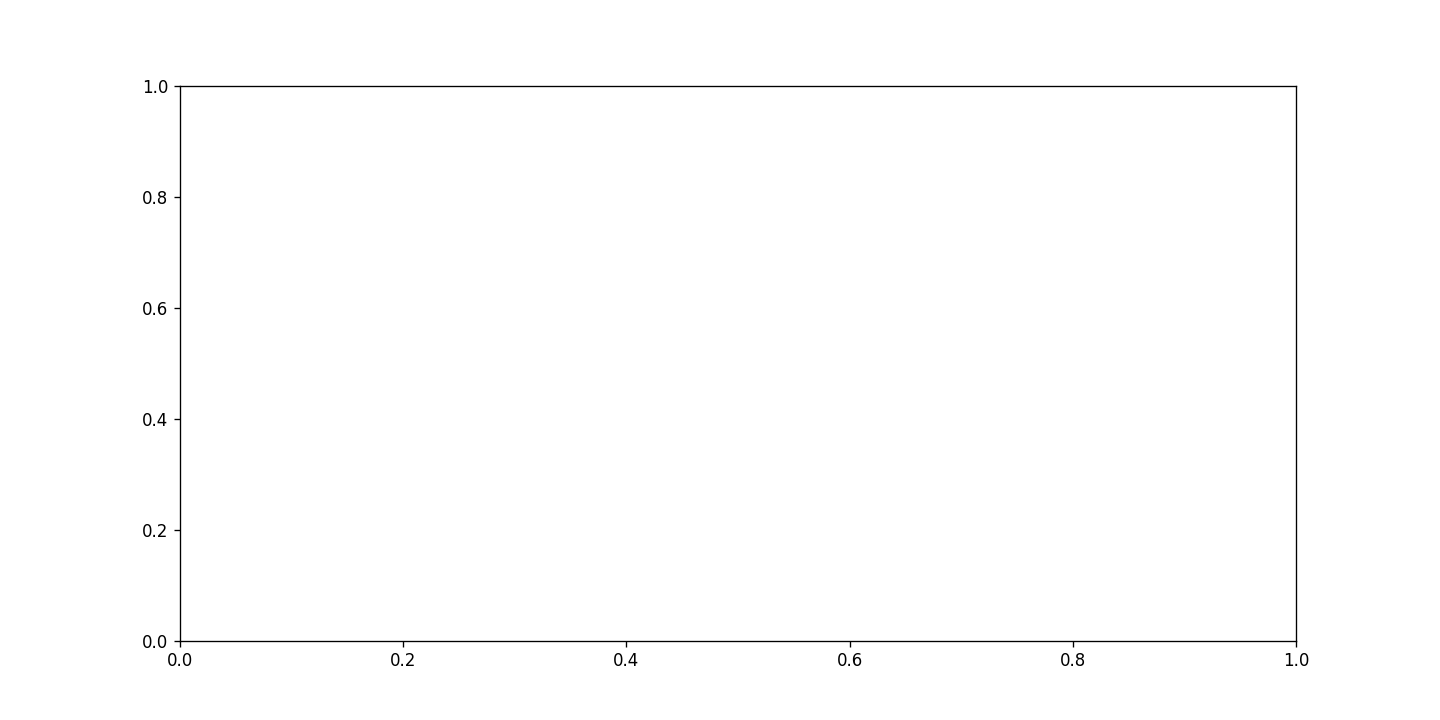

In [43]:
#data = {
    #"rf sweep": (328868, 328882), # scan rf center_detuning from -200kHz to 200kHz. Each step has 50kHz scan
    #"rf sweep 2": (329553, 329572),
    #"rf hsh 10 kHz scan range": (329204, 329223), # scan rf center_detuning from -200kHz to 200kHz. Each step has 10kHz scan
    #"rf hsh": (329224, 329243), # scan rf center_detuning from -200kHz to 200kHz. Each step has 50kHz scan
    #"rf hsh 2": (329533,329552),
#}

# data = { # comparing sine sweep with HSH pulse, averaged over 5 scans. 
#     "rf sweep": (329617, 329636), # scan rf center_detuning from -200kHz to 200kHz. Each step has 50kHz scan
#     "rf sweep 2": (329637, 329656),
#     "rf sweep 3": (329657, 329676),
#     "rf sweep 4": (329677, 329696),
#     "rf sweep 5": (329697, 329716),
#     "rf hsh": (329717, 329736), # scan rf center_detuning from -200kHz to 200kHz. Each step has 50kHz scan
#     "rf hsh 2": (329737, 329756),
#     "rf hsh 3": (329757, 329776),
#     "rf hsh 4": (329777, 329796),
#     "rf hsh 5": (329797, 329816),
# }


fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
sweeps = []
hsh_pulses = []
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["rf"]["center_detuning"].to("kHz").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    if "sweep" in label:
        sweeps.append(ys)
    elif "hsh" in label:
        hsh_pulses.append(ys)
    #ax.scatter(xs, ys, label=label)

avg_sweep = np.mean(sweeps, axis = 0)
avg_hsh = np.mean(hsh_pulses, axis = 0)
ax.scatter(xs, avg_sweep, label = "avg sweep")
ax.scatter(xs, avg_hsh, label = "avg hsh")
ax.set_xlabel("RF HSH center detuning from the Zeeman transition average (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## LF Spectroscopy on b, bbar Transition

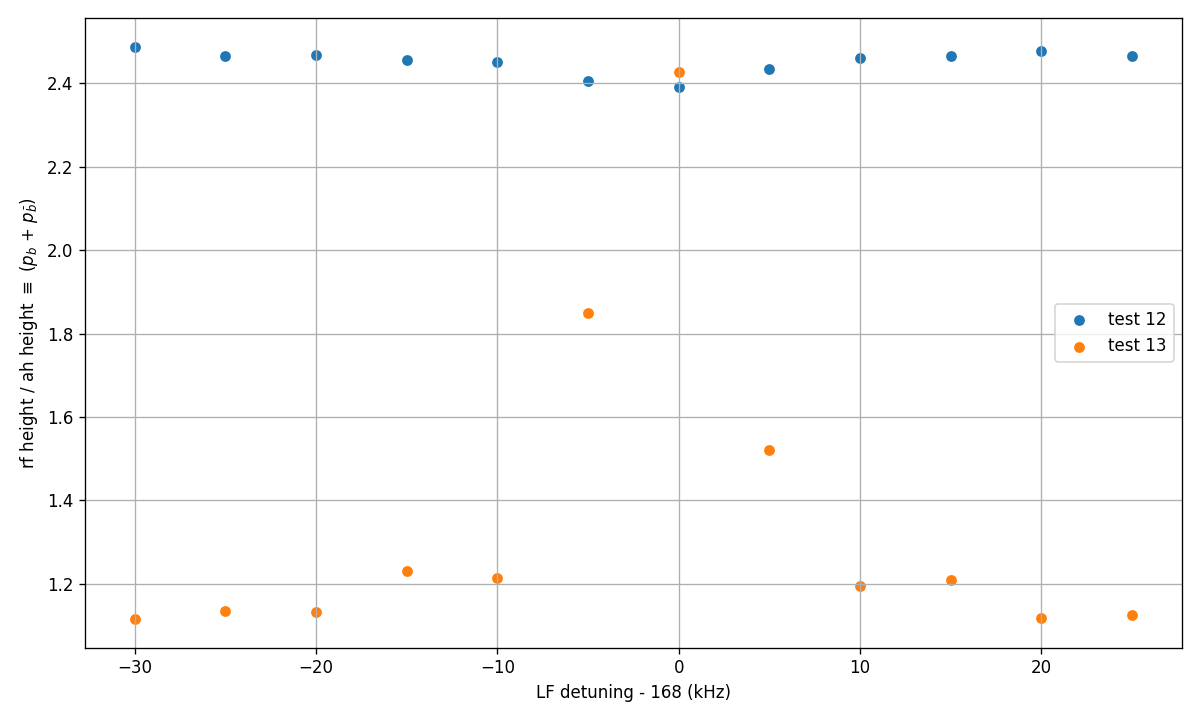

In [387]:
data = {
    "lf scan": (328888, 328927), # heating is an issue, nothing shows
    "lf scan, 1": (328928, 328967), # repeat of above
    "manual": (329029, 329066), # switch AWG for function generator
    "manual, 1": (329069, 329108), #repeat of above
    #"lf off": (329266,329384), # no lf, shows background due to heating
    #"lf scan, 2": (329385,329464) # same as first two
    #"lf scan with delays": (329817, 329896), # step size 0.5 kHz, 1 s delay between steps
    "lf scan with delay": (329897, 330056), # step size 0.25 kHz, 1 s delay between steps
    "lf scan prepare bbar": (330097, 330256)
}
data = {
    "rf test 0.3 ms, rf sweep off": (529783, 529812),
    "rf test 0.2 ms, rf sweep off": (529813, 529828),
    "rf test 0.5 ms, rf sweep off": (529829, 529839),
    "rf test 0.5 ms, rf sweep off, longer antihole": (529858, 529867),
    "rf test 0.5 ms, rf sweep off, antihole rf assist": (529871, 529900),
    "rf test 0.5 ms, rf sweep -110 to -10, antihole rf assist": (529901, 529930),
    "rf test 0.5 ms, rf sweep -110 to -10, antihole rf assist, repeat": (529946, 529975),
    "rf test 0.5 ms, rf sweep -80 to -40, antihole rf assist": (529976, 529990),
}
data = {
    # ramsey data
    "1 ms wait, 7 us pi/2": (530343, 530366),
    "1 ms wait, 7 us pi/2, repeat": (530367, 530396),
}
data = {
    #"lf test, 8000 amplitude, 30 ms": (530006, 530045),
    # "lf test, 8000 amplitude, 30 ms, broader": (530046, 530065),
    # "lf test, 2000 amplitude, 30 ms": (530066, 530085),
    # "lf test, 500 amplitude, 30 ms": (530086, 530105),
    # "lf test, 500 amplitude, 1 ms": (530106, 530125),
    # "lf test, 0 amplitude, 1 ms": (530126, 530145),
    #"lf test, 2000 amplitude, 0.1 ms": (530146, 530165),
    # "bƀ, 1000 amplitude, 0.1 ms": (530166, 530185),
    # "lf test, 1000 amplitude, 0.1 ms, repeat": (531319, 531338),
    #"lf test, 250 amplitude, 0.4 ms": (531339, 531405),
    #"lf test, 100 amplitude, 1 ms": (531406, 531472),
    #"lf test, 200 amplitude, 0.5 ms": (531473, 531539),
    #"lf test, 250 amplitude, 0.4 ms, after fridge stabilization": (531540, 531559),
    #"lf test, 150 amplitude, 0.4 ms": (531560, 531579),
    #"lf test, 125 amplitude, 0.4 ms": (531580, 531619),
    #"lf test, 125 amplitude, 0.4 ms sech": (531620, 531659),
    # "lf test, 125 amplitude, 0.4 ms sech, HSH": (531660, 531699),
    #"lf test, 50 amplitude, 0.4 ms sech, HSH": (531700, 531739),
    #"lf test, 90 amplitude, 0.7 ms sech, HSH": (531740, 531779),

    # "b lf test after code change -- start in b": (531948, 531967),
    # "a, 4000 amplitude, 305 kHz, 0.1 ms": (531968, 531987),
    # "aā, 4000 amplitude, 0.4 ms": (532098, 532111),
    # "aā, 2000 amplitude, 0.8 ms": (532112, 532131),

    # "bƀ, 30 amplitude, 2 ms": (532267, 532306),
    # "bƀ, 120 amplitude, 0.5 ms": (532307, 532316),
    # "bƀ, 60 amplitude, 1 ms": (532317, 532326),
    # "bƀ, 30 amplitude, 2 ms": (532327, 532336),

    
    # "bƀ, 60 amplitude, 1 ms - dense": (532338, 532367),
    # "bƀ, 60 amplitude, 1 ms - dense - again": (532368, 532397),
    # "bƀ, 60 amplitude, 1 ms - dense - flip": (532398, 532427),
    
    # "aā, 800 amplitude, 1 ms - dense": (532428, 532457),
    # "aā, 800 amplitude, 1 ms - dense - again": (532458, 532487),
    # "aā, 800 amplitude, 1 ms - dense - flip": (532488, 532517),
    
    # "aā, 800 amplitude - 1 ms": (532428, 532487),
    # "bƀ, 60 amplitude - 1 ms": (532338, 532427)

    "test 12": (534351, 534362),
    "test 13": (534363, 534374),
}

def averaging_ys(xs, ys):
    xs_unique = np.unique(xs)
    ys_to_avg = [[] for _ in range(len(xs_unique))]
    for x, y in zip(xs, ys):
        ys_to_avg[np.argwhere(xs_unique == x)[0][0]].append(y)
    ys_avg = []
    for y_list in ys_to_avg:
        ys_avg.append(np.average(y_list))
    ys_avg = np.array(ys_avg)
    
    return xs_unique, ys_avg
    

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    xs, ys = averaging_ys(xs, ys)
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

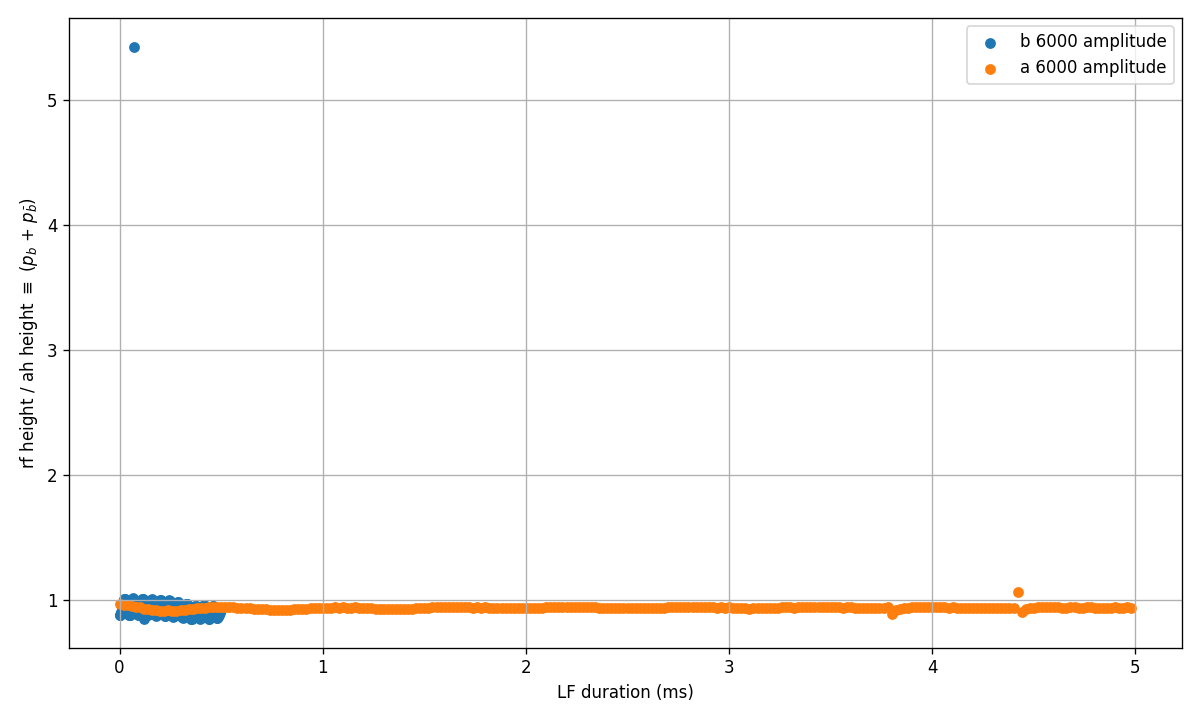

In [379]:
data = {
    # "lf 1000 amplitude": (530186, 530205),
    # "lf 8000 amplitude": (530226, 530245),
    # "b lf 8000 amplitude, shorter": (530266, 530285),
    # "lf 8000 amplitude, 1": (530396, 530396 + 922 - 1),

    # "aabar lf 4000 amplitude, 302 kHz": (531988, 532007),
    # "a lf 8000 amplitude, 302 kHz, longer": (532008, 532037),
    # "a lf 8000 amplitude, 302 kHz, longer, again": (532038, 532067),
    # "a lf 8000 amplitude, 302 kHz, longer, longer": (532068, 532097),
    
    # "a lf 800 amplitude": (532132, 532161),
    # "a lf 400 amplitude": (532162, 532191),
    # "b lf 40 amplitude": (532207, 532234),
    # "b lf 30 amplitude": (532237, 532266),
    
    # "b lf 6000 amplitude": (532788, 532822),
    "b 6000 amplitude": (533030, 533279),
    "a 6000 amplitude": (533280, 533529),
    # "b 6000 amplitude 2": (533530, 533779),
    # "b 6000 amplitude 3": (533780, 534029),
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["duration"].to("ms").magnitude for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF duration (ms)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

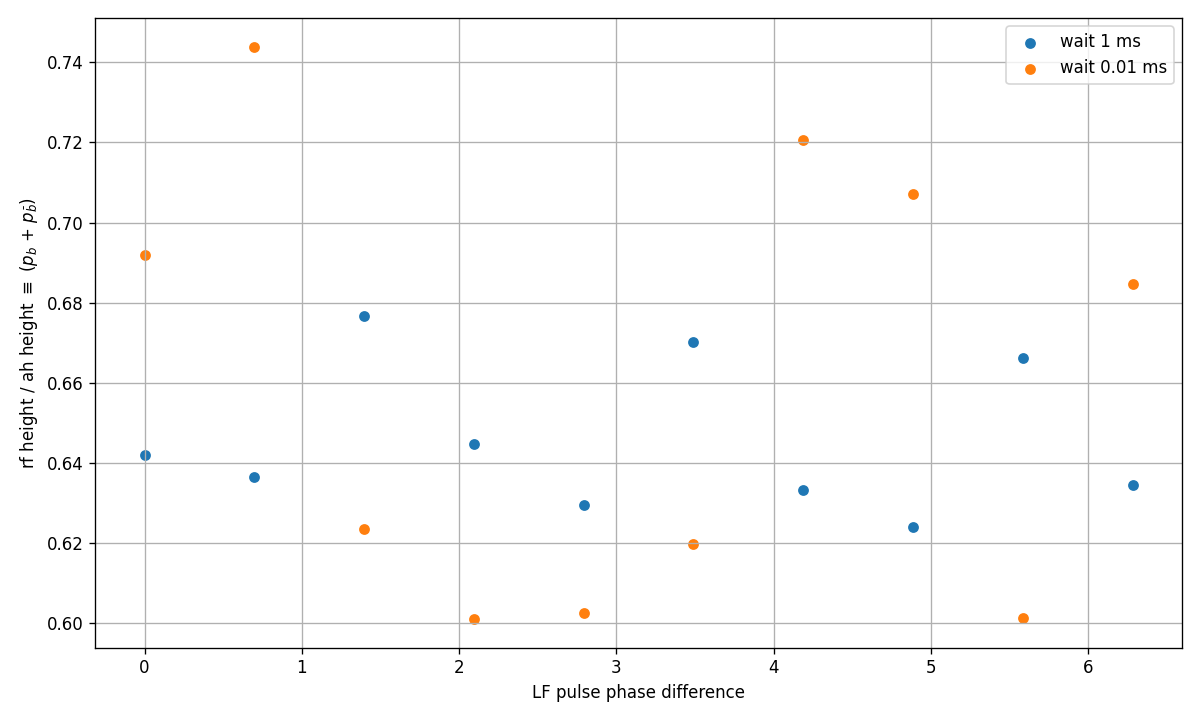

In [31]:
## Ramsey
data = {
    "wait 1 ms": (530306, 530315),
    "wait 0.01 ms": (530316, 530325),
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["phase_diff"] for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF pulse phase difference")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## LF Spin Echo bbbar

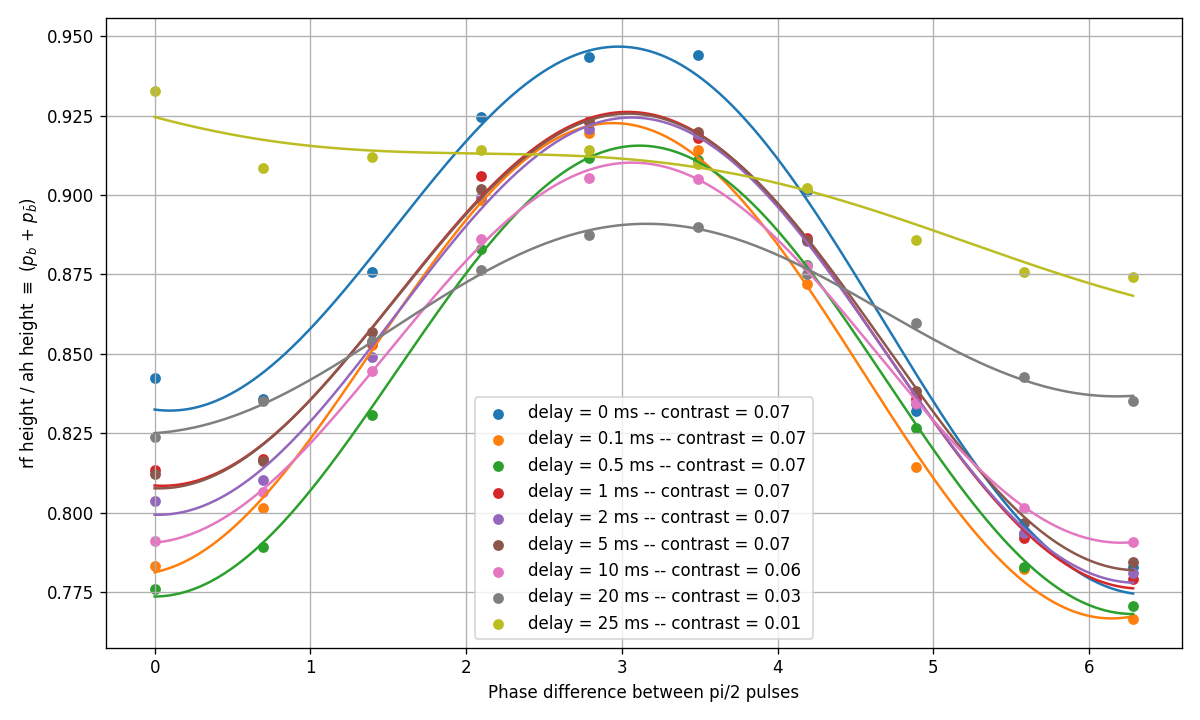

In [330]:
def sine_func(phi, a, theta, b, c) :
    return a * np.sin(phi + theta) + b*phi + c

def sineFit(xs, ys):
    fitter = Fitter(sine_func)
    fitter.set_absolute_sigma(False)
    fitter.set_data(xs, ys)
    fitter.fit(maxfev = 10000)
    return fitter

data = {
    # "6000 amplitude, 0.025 ms pi time, 0 ms delay": (532828, 532837),
    "6000 amplitude, 0.025 ms pi time, 0 ms delay": (532838, 532847),
    "6000 amplitude, 0.025 ms pi time, 0.1 ms delay": (532848, 532857),
    "6000 amplitude, 0.025 ms pi time, 0.5 ms delay": (532858, 532867),
    "6000 amplitude, 0.025 ms pi time, 1 ms delay": (532868, 532877),
    "6000 amplitude, 0.025 ms pi time, 2 ms delay": (532878, 532887),
    "6000 amplitude, 0.025 ms pi time, 5 ms delay": (532888, 532897),
    "6000 amplitude, 0.025 ms pi time, 10 ms delay": (532898, 532907),
    "6000 amplitude, 0.025 ms pi time, 20 ms delay": (532908, 532917),
    "6000 amplitude, 0.025 ms pi time, 25 ms delay": (532918, 532927),
}

contrasts_b = []
delays_b = []
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["phase"] for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    
    gaussian_fit = sineFit(xs, ys)
    xs_fit = np.linspace(np.min(xs), np.max(xs), 1000)
    ax.plot(xs_fit, gaussian_fit.fitted_value(xs_fit))

    contrast = abs(gaussian_fit.results["a"])
    delay = headers[0]["params"]["lf"]["delay_time"].to("ms").magnitude
    
    contrasts_b.append(contrast)
    delays_b.append(delay)
    
    ax.scatter(xs, ys, label=f"delay = {delay} ms -- contrast = {contrast:.2f}", s = 30)


ax.set_xlabel(f"Phase difference between pi/2 pulses")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## LF Spin Echo aabar

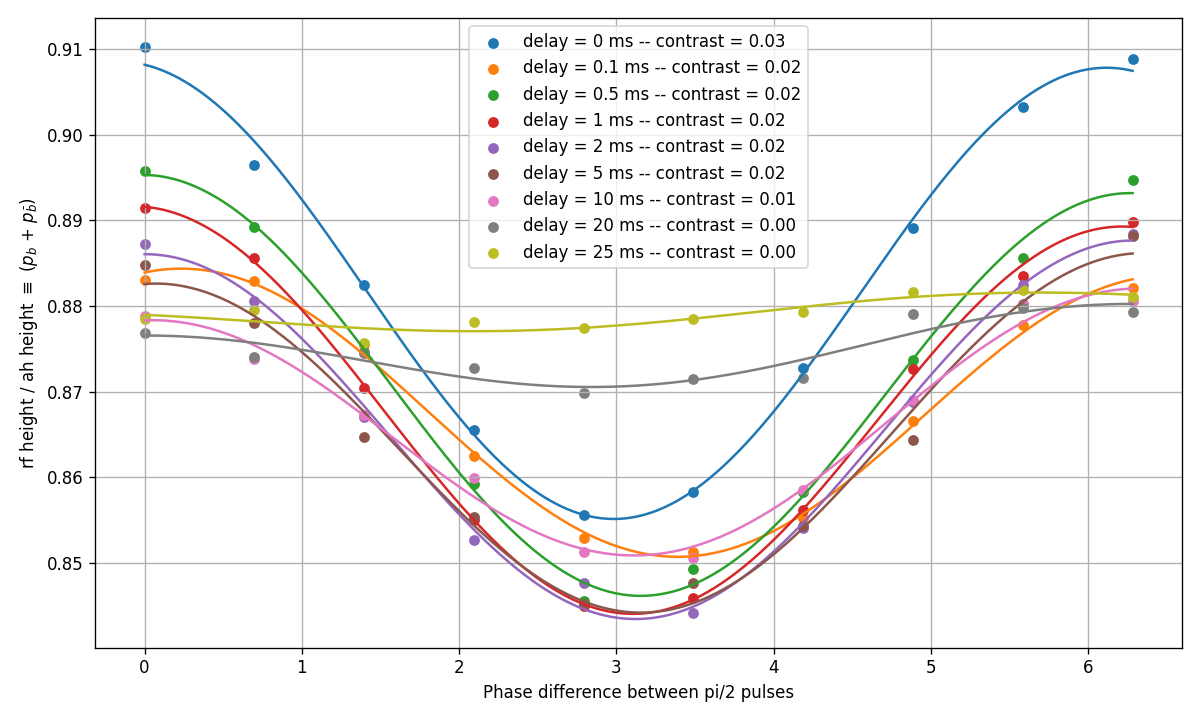

In [331]:
data = {
    # "6000 amplitude, 0.33 ms pi time, 0 ms delay": (532928, 532937),
    "6000 amplitude, 0.33 ms pi time, 0 ms delay": (532938, 532947),
    "6000 amplitude, 0.33 ms pi time, 0.1 ms delay": (532948, 532957),
    "6000 amplitude, 0.33 ms pi time, 0.5 ms delay": (532958, 532967),
    "6000 amplitude, 0.33 ms pi time, 1 ms delay": (532968, 532977),
    "6000 amplitude, 0.33 ms pi time, 2 ms delay": (532978, 532987),
    "6000 amplitude, 0.33 ms pi time, 5 ms delay": (532988, 532997),
    "6000 amplitude, 0.33 ms pi time, 10 ms delay": (532998, 533007),
    "6000 amplitude, 0.33 ms pi time, 20 ms delay": (533008, 533017),
    "6000 amplitude, 0.33 ms pi time, 25 ms delay": (533018, 533027),
}

contrasts_a = []
delays_a = []
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["phase"] for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    
    gaussian_fit = sineFit(xs, ys)
    xs_fit = np.linspace(np.min(xs), np.max(xs), 1000)
    ax.plot(xs_fit, gaussian_fit.fitted_value(xs_fit))

    contrast = abs(gaussian_fit.results["a"])
    delay = headers[0]["params"]["lf"]["delay_time"].to("ms").magnitude
    
    contrasts_a.append(contrast)
    delays_a.append(delay)
    
    ax.scatter(xs, ys, label=f"delay = {delay} ms -- contrast = {contrast:.2f}", s = 30)


ax.set_xlabel(f"Phase difference between pi/2 pulses")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

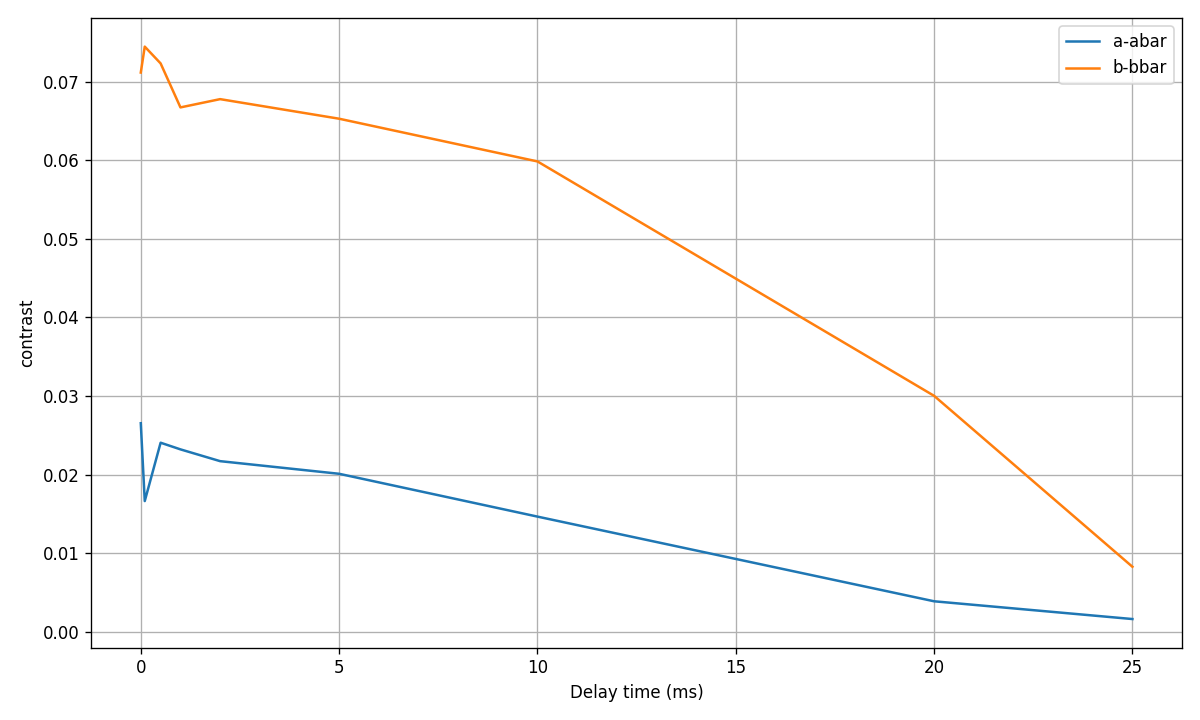

In [333]:
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
ax.plot(delays_a, contrasts_a, label="a-abar")
ax.plot(delays_b, contrasts_b, label="b-bbar")
ax.set_xlabel(f"Delay time (ms)")
ax.set_ylabel("contrast")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## Hole and AOM only

In [390]:
def get_average_heights(data_number):
    data, headers = get_experiment_data(data_number)

    detunings_MHz = headers["detunings"].to("MHz").magnitude
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    
    plt_monitor = True
    use_positive = None
    
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        chasm_avg = None
        antihole_normalized = antihole_avg / monitors_avg["antihole"]
        rf_normalized = rf_avg / monitors_avg["rf"]
    return np.average(antihole_normalized), np.average(rf_normalized), headers

def get_voltage_ratios(data_list):
    ratios = []
    headers = []
    for kk in data_list:
        h1, h2, header = get_average_heights(kk)
        ratios.append(h2 / h1)
        headers.append(header)
    return np.array(ratios), headers

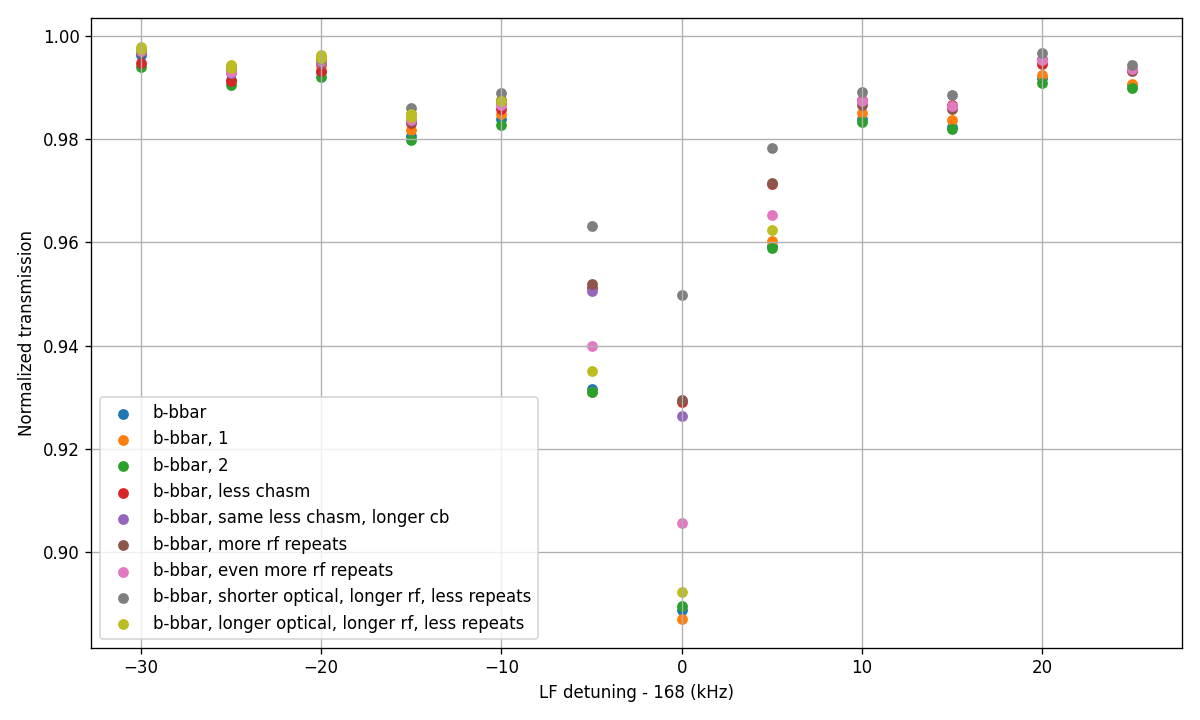

In [467]:
data = {
    "b-bbar": (534491, 534502),
    "b-bbar, 1": (534503, 534514),
    "b-bbar, 2": (534572, 534583),
    "b-bbar, less chasm": (534584, 534595),
    "b-bbar, same less chasm, longer cb": (534596, 534602),
    "b-bbar, more rf repeats": (534603, 534614),
    "b-bbar, even more rf repeats": (534615, 534626),
    "b-bbar, shorter optical, longer rf, less repeats": (534627, 534638),
    "b-bbar, longer optical, longer rf, less repeats": (534639, 534650),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = ratios
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized transmission")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

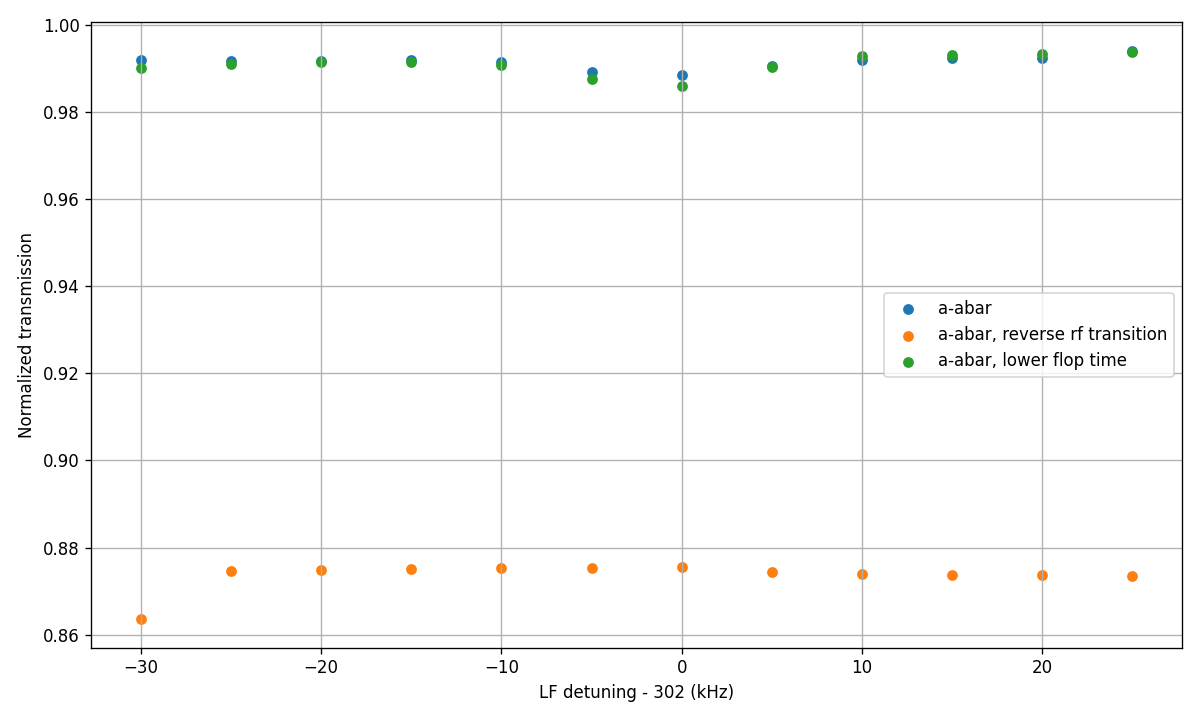

In [430]:
data = {
    "a-abar": (534528, 534539),
    "a-abar, reverse rf transition": (534540, 534551),
    "a-abar, lower flop time": (534552, 534563),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = ratios
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized transmission")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()